### 1) Perform sentimental analysis on the Elon-musk tweets (Exlon-musk.csv) 2) Perform emotion mining

Install necessary packages

In [ ]:
!pip install spacy


In [ ]:
!pip install wordcloud 

In [ ]:
!pip install plotly==5.20.0

In [ ]:
pip install cufflinks

In [348]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string # special operations on strings
import spacy # language models

from matplotlib.pyplot import imread
from matplotlib import pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
import re
from sklearn.feature_extraction.text import CountVectorizer
from plotly.offline import iplot
import warnings
warnings.filterwarnings('ignore')

### EDA 

In [406]:
import pandas
elonMusk_df = pd.read_csv("Elon_musk.csv",encoding='latin-1')


In [407]:
elonMusk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1999 non-null   int64 
 1   Text        1999 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [408]:
elonMusk_df.drop(columns="Unnamed: 0",inplace=True)

In [409]:
elonMusk_df

,Text
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


### Preprocessing

Clean the dataset 

In [410]:

def cleanSentence(comments):
    if comments.isnumeric(): comments=""
    else:
        comments = re.sub(r'@[\w_]+[\s,:]','',comments)
        comments = re.sub(r'RT\s','',comments)
        comments = re.sub(r'https?:\/\/\S+','',comments)
        comments = re.sub('&amp', 'and',comments)
        comments = re.sub('&gt', '>', comments)
        comments = re.sub('&lt', '<', comments)
        comments = re.sub('[\r\n]+', ' ', comments)
        comments = re.sub(r'#\w+', '', comments)
        comments = re.sub('\\n', '',comments)
        comments = re.sub(r'<[A-Z0-9+]+>', '',comments)
        comments = re.sub('[^A-Za-z0-9]+', ' ',comments)
        comments = re.sub('haha','',comments)
        comments = re.sub('\sye\s','',comments)
        comments = comments.lower()
        
    
    return comments

In [411]:
# Create a new column with the cleaned tweets

elonMusk_df['Cleaned_Text'] = elonMusk_df['Text'].apply(cleanSentence)

In [412]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [413]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(elonMusk_df['Cleaned_Text'], 20)

df_new = pd.DataFrame(common_words, columns = ['TweetText' , 'count'])
df_new.groupby('TweetText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar',
    yTitle='Count',
    linecolor='black',
    title='Top 20 bigrams in Tweets')

### Emotion mining

In [414]:
import nltk
nltk.download('punkt')
from nltk import tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/priyaramesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [415]:
#Sentiment analysis
afinn = pd.read_csv('Afinn.csv', sep=',', encoding='latin-1')
afinn.shape

(2477, 2)

In [416]:
affinity_scores = afinn.set_index('word')['value'].to_dict()

In [417]:
elonMusk_df.drop(elonMusk_df[elonMusk_df['Cleaned_Text']==""].index, inplace = True)

In [418]:
sentence = elonMusk_df['Cleaned_Text']

In [421]:
#Custom function :score each word in a sentence in lemmatised form,
#but calculate the score for the whole original sentence.
nlp = spacy.load('en_core_web_sm')
sentiment_lexicon = affinity_scores

def calculate_sentiment(text: str = None):
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0)
    return sent_score

In [422]:
elonMusk_df['sentiment_value'] = elonMusk_df['Cleaned_Text'].apply(calculate_sentiment)

In [423]:
elonMusk_df['word_count'] = elonMusk_df['Cleaned_Text'].str.split().apply(len)

In [424]:
elonMusk_df.sort_values(by='sentiment_value').tail(10)

,Text,Cleaned_Text,sentiment_value,word_count
859,@TesLatino Thanks to a great Autopilot/AI team...,thanks to a great autopilot ai team working su...,7,17
1786,@flcnhvy @yourfavgas @ajtourville I really wan...,i really want to do this will be great fun cou...,8,16
514,"@Space_Station @SpaceX Wow, Station looks amaz...",wow station looks amazing,8,4
1966,@nichegamer I didnt mind DA2. DA1 was awesome...,i didn t mind da2 da1 was awesome mass effect ...,8,16
468,@picot_john @CyberpunkGame Its a good to grea...,it s a good to great game imo but improving wh...,10,18
458,@teslaownerssv It will get absurdly good. Tesl...,it will get absurdly good tesla ai autopilot e...,10,18
1172,Thanks Tesla Team for great work on deliveries...,thanks tesla team for great work on deliveries...,10,19
1357,Great trip to Germany. Support from government...,great trip to germany support from government ...,10,12
1304,"One way or another, excitement guaranteed! Sup...",one way or another excitement guaranteed suppo...,11,17
1388,"@GerberKawasaki Wow, I super loved astronomy (...",wow i super loved astronomy but took it at que...,12,18


In [425]:
for indx,items in elonMusk_df.iterrows():
    
    if items['word_count'] == 1 and items['Cleaned_Text']=='yes':elonMusk_df.drop(indx,inplace=True)
        

### Visualization

In [426]:
# Needed imports for WordCloud, Lemmatization, and Mask Image
from PIL import Image
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Initialize Lemmatize
wordnet_lem = WordNetLemmatizer()

# Lemmatize processed text and join everything in a list
elonMusk_df['text_lem'] = elonMusk_df['Cleaned_Text'].apply(wordnet_lem.lemmatize)
all_words_lem = ' '.join([word for word in elonMusk_df['text_lem']])

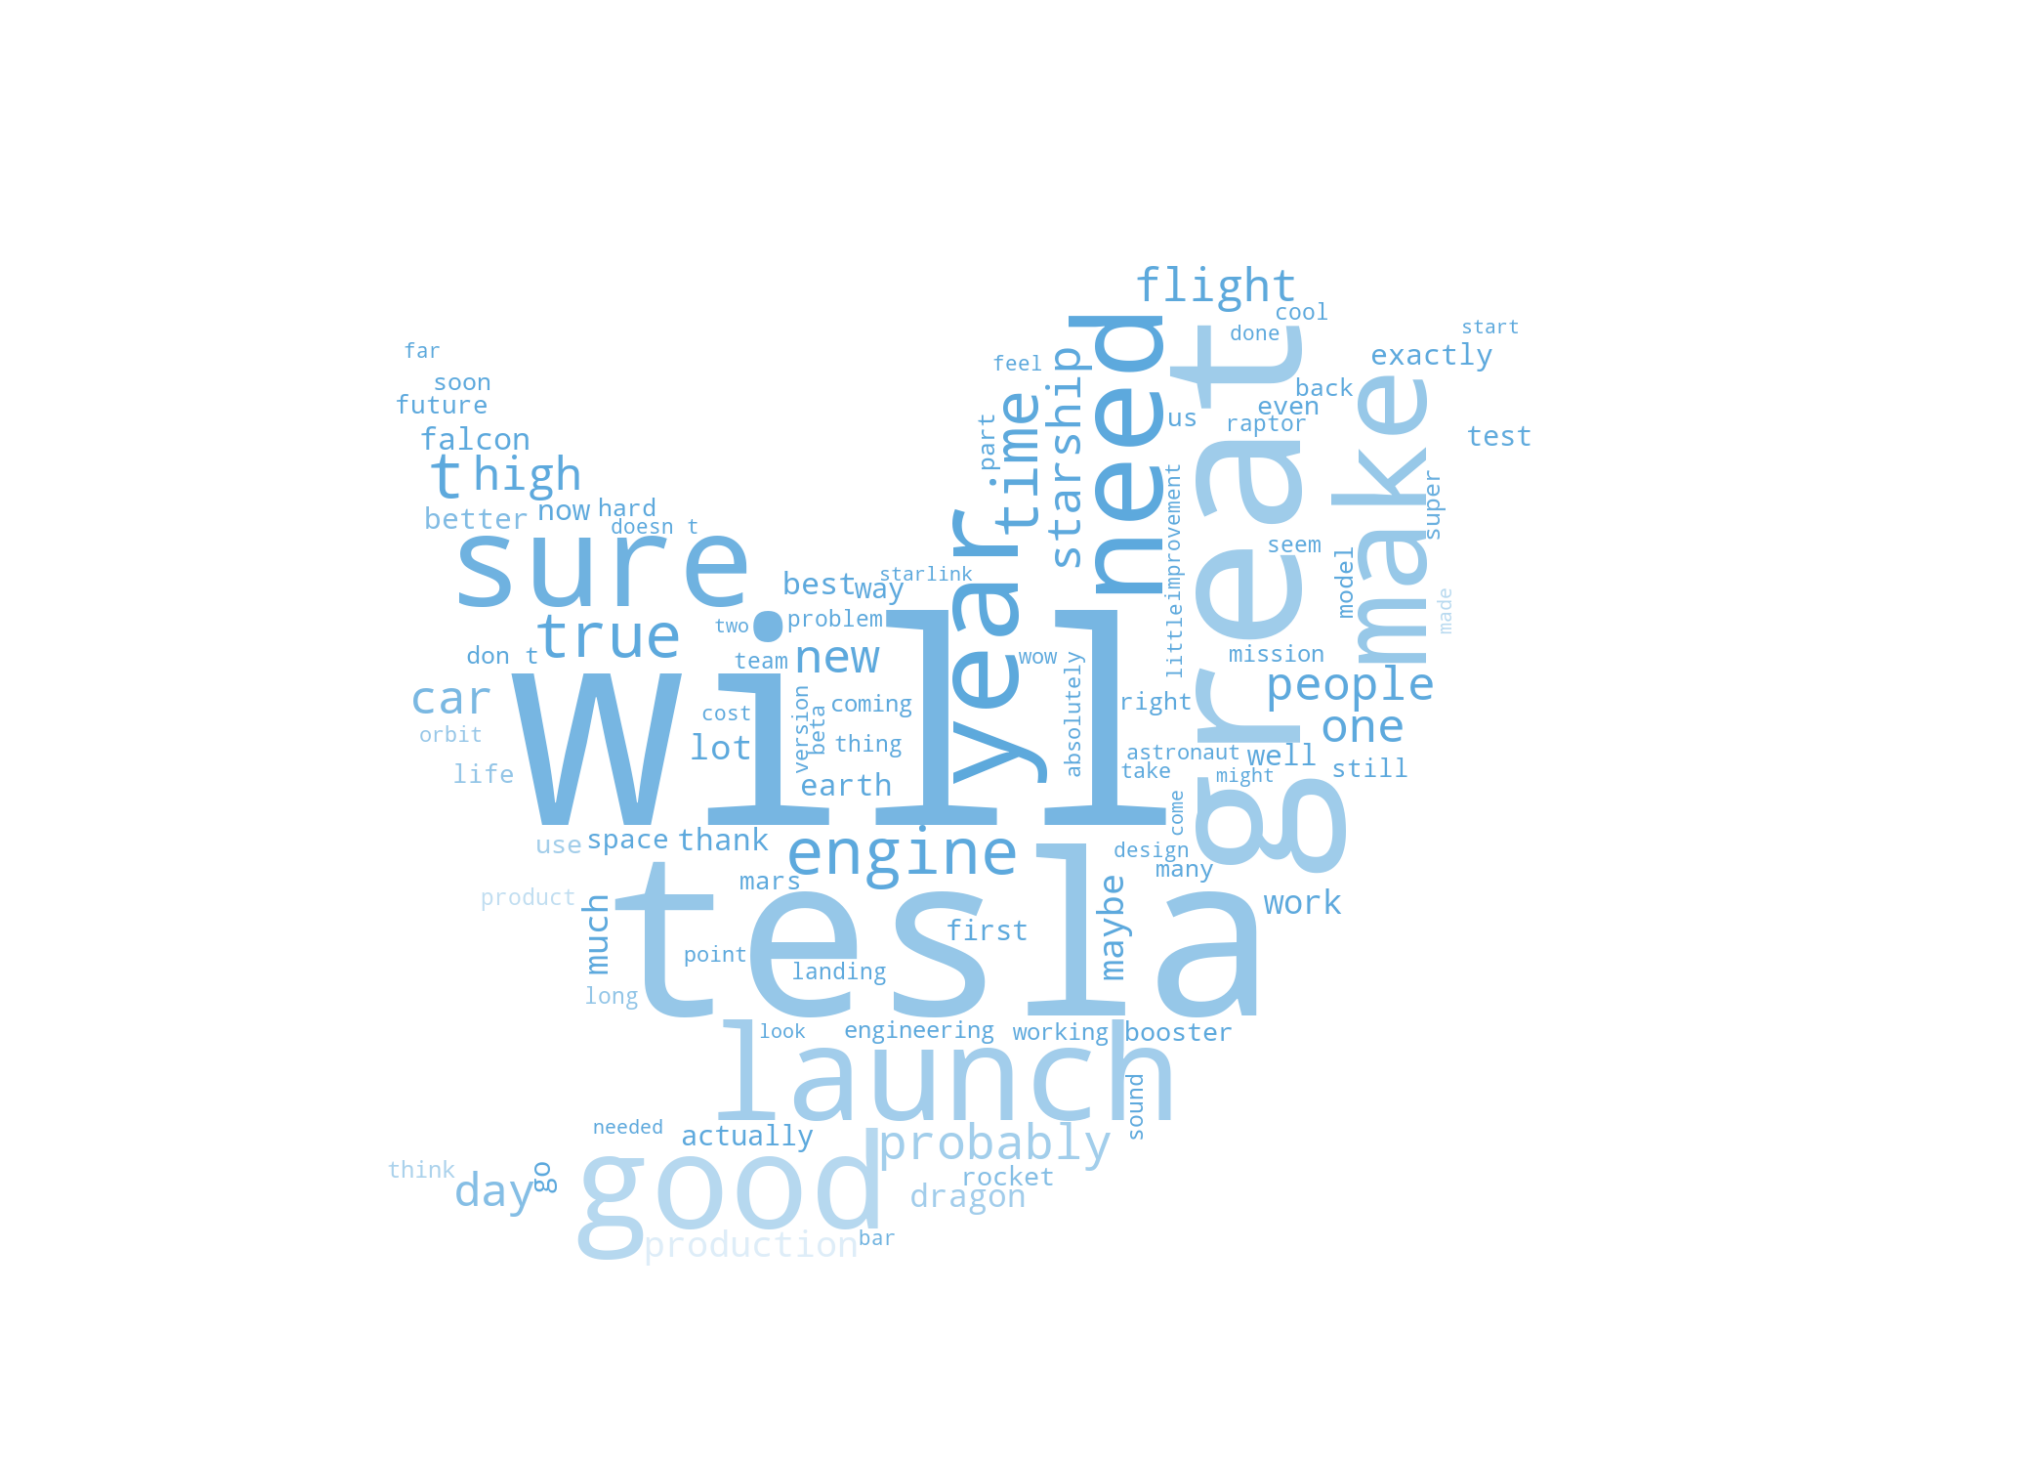

In [427]:
# Generate a word cloud image
mask = np.array(Image.open("tweet.jpg"))
stopwords = set(STOPWORDS)
stopwords.update(["s","elon musk","elon","musk","spacex","yes","ok","haha","don  t","m","ok","re","u","yup","yeah","fsd"]) 
wordcloud_twitter = WordCloud(height=1000,
                              width=1000,
                              background_color="white",
                              mode="RGBA",
                              max_words=100,
                              stopwords=stopwords,
                              mask=mask).generate(all_words_lem)

# Create coloring from the image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=image_colors), interpolation="bilinear")

# Store visualization to file
#plt.savefig("twitter_logo.png", format="png")

plt.show()

In [428]:
# Sentiment score of the whole review
elonMusk_df['sentiment_value'].describe()

count    1839.000000
mean        0.733007
std         1.861339
min        -7.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        12.000000
Name: sentiment_value, dtype: float64

<Axes: xlabel='sentiment_value', ylabel='Density'>

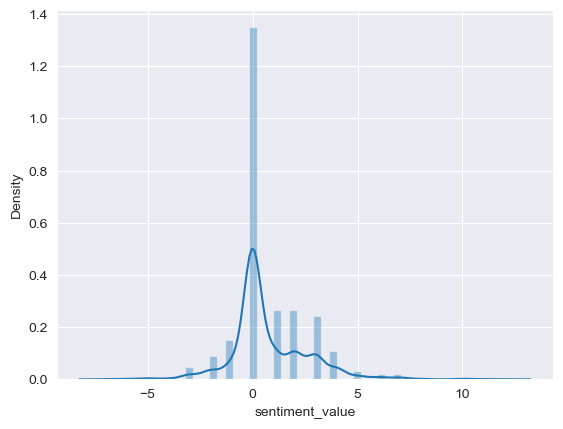

In [429]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(elonMusk_df['sentiment_value'])

<Axes: xlabel='index', ylabel='sentiment_value'>

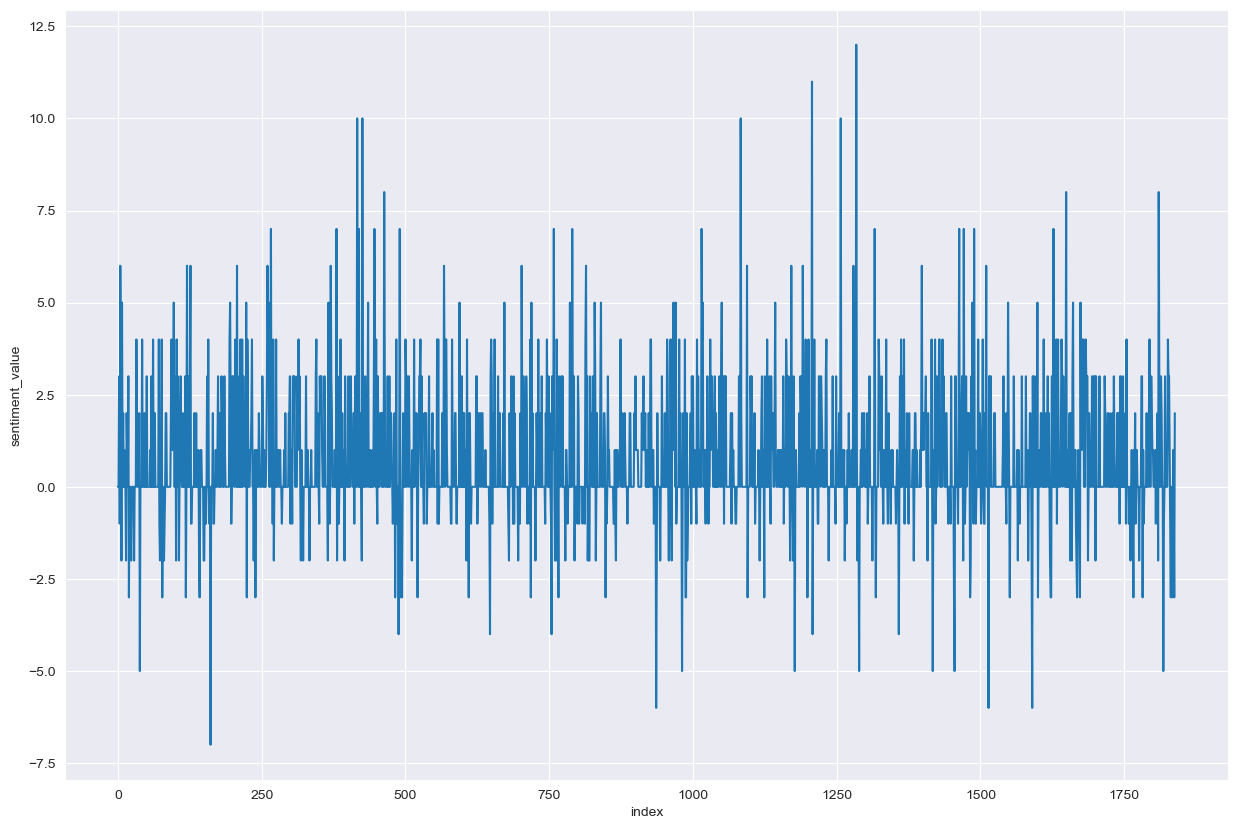

In [430]:
elonMusk_df['index']=range(0,len(elonMusk_df))
plt.figure(figsize=(15, 10))
sns.lineplot(y='sentiment_value',x='index',data=elonMusk_df)

<Axes: title={'center': 'Sentence sentiment value to sentence word count'}, xlabel='word_count', ylabel='sentiment_value'>

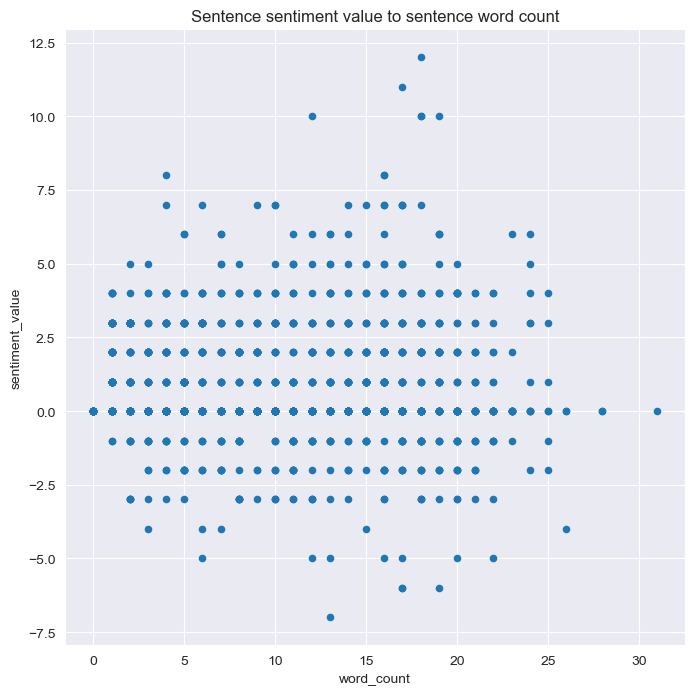

In [431]:
elonMusk_df.plot.scatter(x='word_count', y='sentiment_value', figsize=(8,8), title='Sentence sentiment value to sentence word count')

In [432]:
def getSentiment(value):
    if value < 0:return 'Negative'
    elif value > 0:return 'Positive'
    else:return 'Neutral'

In [433]:
elonMusk_df['Sentiment'] = elonMusk_df['sentiment_value'].apply(getSentiment)

In [434]:
elonMusk_df.head(5)

,Text,Cleaned_Text,sentiment_value,word_count,text_lem,index,Sentiment
0,@kunalb11 Im an alien,i m an alien,0,4,i m an alien,0,Neutral
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is next leve...,0,13,ray tracing on cyberpunk with hdr is next leve...,1,Neutral
2,@joerogan @Spotify Great interview!,great interview,3,2,great interview,2,Positive
3,@gtera27 Doge is underestimated,doge is underestimated,-1,3,doge is underestimated,3,Negative
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,6,16,congratulations tesla china for amazing execut...,4,Positive


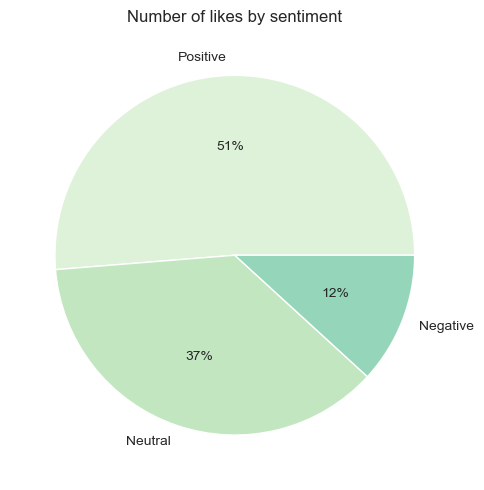

In [435]:
plt.figure(figsize = (10, 5))

data = elonMusk_df['Sentiment'].value_counts()
colors = sns.color_palette('GnBu')
labels = ['Positive', 'Neutral', 'Negative']

plt.pie(data, labels = labels, autopct = '%.0f%%', colors = colors)
plt.title('Number of likes by sentiment')

plt.tight_layout()